In [17]:
import nfl_data_py as nfl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Machine Learning Project: Predict blitz based on certain metrics

## Part I: Exploratory Data Analysis

Using the eye test, a major predictor in whether or not a defense is going to blitz is the personnel on the field. Using this knowledge, lets take a look at a total number of snaps each amount of defenders in the box have accounted for.

2023 done.
Downcasting floats.


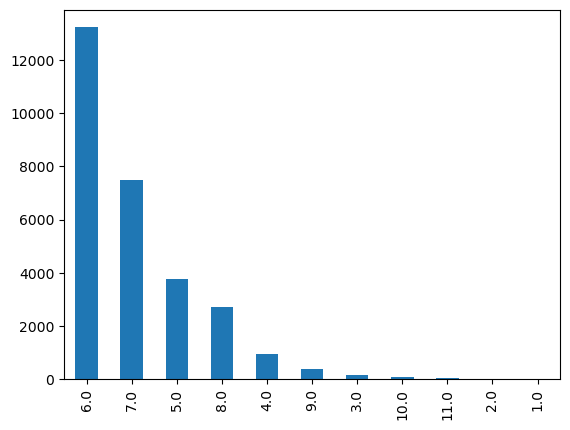

In [18]:
#import pbp data for 2023 season
pbp = nfl.import_pbp_data([2023])
#save data to csv
pbp.to_csv('2023pbp.csv')
#plot counts of different amounts of defenders in the box
pbp['defenders_in_box'].value_counts().plot(kind='bar')
plt.show()


This plot shows that a lot of snaps have 6 defenders in the box, with 7 defenders in the box coming in at second. Let's explore the data a bit more.

What we do know, is that when quarterback is blitzed, it usually means they were pressured. Let's take a look at how many snaps in the data had the quarterback under pressure.

In [19]:
pbp = pd.read_csv('2023pbp.csv')
pbp['was_pressure'].value_counts()

/var/folders/_q/9sh2684d1t57tq5wdp7xn8s80000gn/T/ipykernel_26432/1365564665.py:1: DtypeWarning: Columns (180,181,183,184,190,191,204,205,206,207,214,215,219,220,221,223,225,227,254,255,256,261,263,264,284,285,333) have mixed types. Specify dtype option on import or set low_memory=False.
  pbp = pd.read_csv('2023pbp.csv')


False    10221
True      4531
Name: was_pressure, dtype: int64

Interesting! It's time to dive deeper into the data.

Let's clean up the table a little bit. By keeping the columns that are listed below, we are able to gain further insight as to what pre-snap variables play an important role in determining wether or not a quarterback will be pressured.

In [20]:
#cleaning
pbp = pbp[['sack','possession_team','offense_formation','offense_personnel','defenders_in_box','defense_personnel','number_of_pass_rushers', 'down', 'ydstogo', 'was_pressure','route','defense_man_zone_type','defense_coverage_type']]
pbp = pbp.dropna()

# # add a was_pressure filter (will comment out when it is time to train the model
# pbp = pbp[pbp['was_pressure'] == True]

# # will comment out when it is time to train the model
# #plot the data
# pbp['defenders_in_box'].value_counts().plot(kind='bar')
# plt.show()
# pbp['offense_formation'].value_counts().plot(kind='bar', ylabel='number_of_pressures',xlabel='offense_formation')
# plt.show()
# pbp['defense_man_zone_type'].value_counts().plot(kind='bar')
# plt.show()
# pbp['defense_personnel'].value_counts().plot(kind='bar')
# plt.show()
# pbp['down'].value_counts().plot(kind='bar')
# plt.show()
# pbp['ydstogo'].value_counts().plot(kind='bar')
# plt.show()

#### With the was_pressure filter active and using the histograms above we can gain the following insights:
  * Again, a lot of blitzing occurs when there are **6 defenders in the box**
  * When the offense is in **shotgun formation**, there allows a lot of **time for quarterbacks to be blitzed**
  * There could be another analysis as to why there is **more blitzing in zone coverage vs man coverage**
  * When there are **4 DL, 2 LB, and 5 DB**, there is **likely to be a blitz** vs other defensive personnel
    * We can use **one-hot encoding** to break up the defensive personnel
  * There isn't much insight gained from when the blitzing comes in regards to what down it is, therefore we may ignore that for now
  * One **GLARING** outlier is that there is a lot of blitzing happening when there are **10 yards to go**; afterwards, the probability, based on eye-test, of a blitz occurring for any other scenario is **significantly less**.

In [21]:
#quick one hot encoding
pbp['down'] = pbp['down'].astype('category')
pbp['offense_formation'] = pbp['offense_formation'].astype('category')
pbp['offense_personnel'] = pbp['offense_personnel'].astype('category')
pbp['defense_personnel'] = pbp['defense_personnel'].astype('category')
pbp['route'] = pbp['route'].astype('category')
pbp['defense_man_zone_type'] = pbp['defense_man_zone_type'].astype('category')
pbp['defense_coverage_type'] = pbp['defense_coverage_type'].astype('category')
pbp = pd.get_dummies(pbp,columns=['down','offense_formation','offense_personnel','defense_personnel','route','defense_man_zone_type','defense_coverage_type'])
pbp = pbp.drop(columns=['possession_team'])

#more cleaning
# pbp.drop(columns=['possession_team','offense_formation','offense_personnel','defense_personnel','route','defense_man_zone_type','defense_coverage_type'])
pbp

,sack,defenders_in_box,number_of_pass_rushers,ydstogo,was_pressure,down_1.0,down_2.0,down_3.0,down_4.0,offense_formation_EMPTY,...,defense_man_zone_type_MAN_COVERAGE,defense_man_zone_type_ZONE_COVERAGE,defense_coverage_type_2_MAN,defense_coverage_type_COVER_0,defense_coverage_type_COVER_1,defense_coverage_type_COVER_2,defense_coverage_type_COVER_3,defense_coverage_type_COVER_4,defense_coverage_type_COVER_6,defense_coverage_type_PREVENT
3,0.0,6.0,4.0,7.0,False,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
5,0.0,6.0,4.0,10.0,False,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
6,0.0,6.0,4.0,10.0,True,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
7,0.0,6.0,5.0,10.0,False,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
8,0.0,6.0,4.0,9.0,False,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39369,0.0,6.0,4.0,7.0,False,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
39370,0.0,6.0,4.0,2.0,False,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
39373,0.0,7.0,5.0,10.0,False,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
39381,0.0,7.0,4.0,10.0,False,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


## Part II: Preparing data for the model
We need to split the data into training and testing sets

In [22]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, test_index in sss.split(pbp, pbp['was_pressure']):
    train_set = pbp.iloc[train_index]
    test_set = pbp.iloc[test_index]

x_train = train_set.drop(columns=['was_pressure'])
y_train = train_set['was_pressure']
x_test = test_set.drop(columns=['was_pressure'])
y_test = test_set['was_pressure']

In [23]:
#debugging/testing cell
x_train.astype('int')

,sack,defenders_in_box,number_of_pass_rushers,ydstogo,down_1.0,down_2.0,down_3.0,down_4.0,offense_formation_EMPTY,offense_formation_I_FORM,...,defense_man_zone_type_MAN_COVERAGE,defense_man_zone_type_ZONE_COVERAGE,defense_coverage_type_2_MAN,defense_coverage_type_COVER_0,defense_coverage_type_COVER_1,defense_coverage_type_COVER_2,defense_coverage_type_COVER_3,defense_coverage_type_COVER_4,defense_coverage_type_COVER_6,defense_coverage_type_PREVENT
35361,0,6,4,10,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
31447,0,6,4,6,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
30106,0,7,4,10,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
9467,0,6,5,7,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
34393,0,5,5,8,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25656,0,6,4,16,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
30788,0,6,4,10,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
9592,0,7,4,10,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
12516,0,6,4,10,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


## Part III: Implementing the machine learning model

Now that we have our variables that we want to consider and the data prepared for testing and training, it is time to implement the machine learning model

### XGBoost

In [24]:
xg = XGBClassifier(objective='binary:logistic', random_state=42)
xg.fit(x_train.astype('float64'), y_train.astype('float64'))

xg_pred = pd.DataFrame(xg.predict_proba(x_test.astype('float64')), columns=['prob_not_pressure','prob_pressure'])[['prob_pressure']]

print('XGBoost Brier Score: ', brier_score_loss(y_test.astype('float64'), xg_pred['prob_pressure']))
print('XGBoost Accuracy: ', metrics.accuracy_score(y_test.astype('float64'), xg_pred['prob_pressure'].round()))

XGBoost Brier Score:  0.20182685971998476
XGBoost Accuracy:  0.69534355479841


### Logistic Regression

In [25]:
lr = LogisticRegression()
lr.fit(x_train.astype('float64'),y_train.astype('float64'))
lr_pred = pd.DataFrame(lr.predict_proba(x_test.astype('float64')), columns=['prob_not_pressure','prob_pressure'])[['prob_pressure']]

print('Logistic Regression Brier Score: ',brier_score_loss(y_test.astype('float64'),lr_pred['prob_pressure']))
print('Logistic Regression Accuracy: ',metrics.accuracy_score(y_test.astype('float64'),lr_pred['prob_pressure'].round()))

Logistic Regression Brier Score:  0.1937929133095102
Logistic Regression Accuracy:  0.7189097103918228


/Users/rj/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [26]:
rf = RandomForestClassifier()
rf.fit(x_train.astype('float64'),y_train.astype('float64'))

rf_pred = pd.DataFrame(rf.predict_proba(x_test.astype('float64')), columns=['prob_not_pressure','prob_pressure'])[['prob_pressure']]
print('Random Forest Brier Score: ',brier_score_loss(y_test.astype('float64'),rf_pred['prob_pressure']))
print('Random Forest Accuracy: ',metrics.accuracy_score(y_test.astype('float64'),rf_pred['prob_pressure'].round()))

Random Forest Brier Score:  0.2247495457184737
Random Forest Accuracy:  0.6717773992049971


After implementing a few models, it appears that **Logistic Regression** is the most accurate!

Here are the results together for easier reference:

* XGBoost
  * XGBoost Brier Score:  0.20182685971998476
  * XGBoost Accuracy:  0.69534355479841
* Logistic Regression
  * Logistic Regression Brier Score:  0.1937929133095102
  * Logistic Regression Accuracy:  0.7189097103918228
* Random Forest
  * Random Forest Brier Score:  0.22477313350082867
  * Random Forest Accuracy:  0.6714934696195344

### Which variables were the most important out of the ones considered in the models?

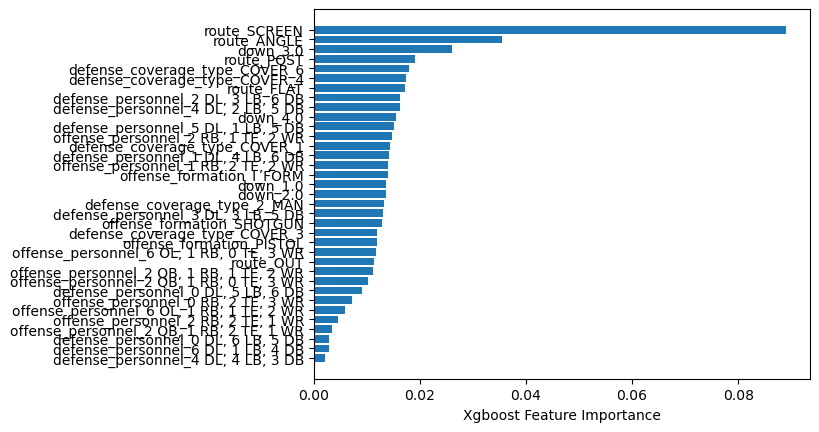

In [29]:
sorted_idx = xg.feature_importances_.argsort()
#get rid of the one hot encoding
sorted_idx = sorted_idx[::2]
#get rid of 0 importance features
sorted_idx = sorted_idx[xg.feature_importances_[sorted_idx] > 0]
plt.barh(x_train.columns[sorted_idx], xg.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

plt.show()